In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import math
import os
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def count_alphabets(input_string):
    """
    Calculate the total number of alphabets and the number of unique alphabets in the input string.

    Parameters:
    input_string (str): The string to analyze.

    Returns:
    tuple: A tuple containing the total number of alphabets and the number of unique alphabets.
    """
    total_alphabets = len(input_string)
    unique_alphabets = len(set(input_string))
    
    return total_alphabets, unique_alphabets

# Example usage
input_string = "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF"
total, unique = count_alphabets(input_string)

print(f"Total number of alphabets: {total}")
print(f"Number of unique alphabets: {unique}")


Total number of alphabets: 42
Number of unique alphabets: 9


(42, 41) (42, 41)


In [4]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=20, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=20, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
        (dropout2): Dropout(p=0.03, inplace=False)
      )
    )
  )
  (encoder): Embedding(8, 20)
  (decoder): Linear(in_features=20, out_features=8, bias=True)
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        print('sssssssssss', predictions.shape)
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

# Training for last four different notes

In [28]:
#last four notes

def getTrainingData(songStrings, nrOfSongs):
    notes = list("ABCDEFGHI")
    chord = [[0], [1], [2], [3], [4], [5], [6], [7],[8]]
    source = []
    target = []
    for s in range(nrOfSongs):
        for i in range(42):
            sentence = []
            answer = []
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return np.array(source), np.array(target)

def split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction):
    total_rows = source.shape[0] // 2
    first_set_rows = int(total_rows * fraction)
    second_set_rows = total_rows - first_set_rows

    first_set_indices = np.random.choice(range(total_rows), first_set_rows, replace=False)
    second_set_indices = np.random.choice(range(total_rows, 2 * total_rows), second_set_rows, replace=False)

    combined_indices = np.concatenate((first_set_indices, second_set_indices))
    np.random.shuffle(combined_indices)

    input_list = source[combined_indices]
    output_list = target[combined_indices]

    return input_list, output_list

# Data generation and preparation
songStrings = np.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEABEF"
])

source_mixed, target_mixed = getTrainingData(songStrings, 2)
fraction = 0.5
input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source_mixed, target_mixed, fraction)

print(input_list.shape, output_list.shape)


(42, 41) (42, 41)


Epoch 1, Loss: 0.0000
sssssssssss torch.Size([41, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_18221/2216166357.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_18221/2216166357.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Epoch 101, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 201, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 301, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 401, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 501, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 601, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 701, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 801, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 901, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1001, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1101, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1201, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1301, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1401, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1501, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1601, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1701, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1801, Loss: 0.000

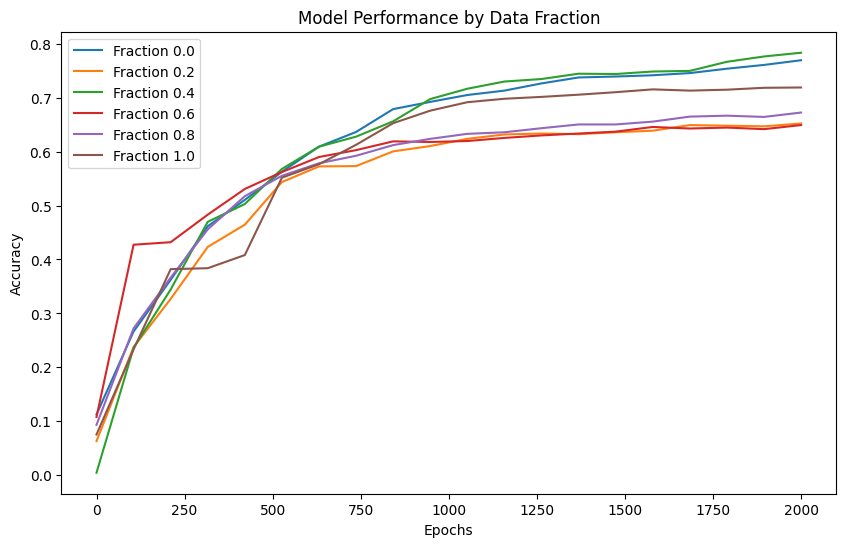

In [44]:
# four notes

# Initialize parameters for the model and environment setup
ntokens = 9  # Size of vocabulary
emsize = 4  # Embedding dimension
nhead = 2  # Number of heads in the nn.MultiheadAttention
d_hid = 4  # Dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # Number of nn.TransformerEncoderLayer
dropout = 0.03  # Dropout probability
learning_rate = 1e-3
num_epochs = 2000
fractions = np.arange(0, 101, 20) / 100
model_dir = "overlap_transformers_four_notes_e4_d4"
os.makedirs(model_dir, exist_ok=True)

source, target = getTrainingData(songStrings, 2)  # Assume this function is properly defined

# Dictionary to store accuracy lists for each fraction
fraction_accuracies = {}

for fraction in fractions:
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

    W = []  # Reset W for each fraction
    model.train()  # Set the model to training mode
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        
        optimizer.zero_grad()  # Clear the gradients
        
        source_tensor = torch.tensor(input_list, dtype=torch.long)
        target_tensor = torch.tensor(output_list, dtype=torch.long)

        src = source_tensor.transpose(0, 1)
        tgt = target_tensor.transpose(0, 1)
        
        output = model(src)
        
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:  # Record accuracy at specified interval
            avg_loss = total_loss / src.size(1)
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            
            acc = test(model, source_tensor, target_tensor)  # Assume this function returns accuracy
            W.append(acc)

    fraction_accuracies[fraction] = W  # Store accuracies for the current fraction

    model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
    torch.save(model.state_dict(), model_save_path)

# Plot all accuracies in the same plot
plt.figure(figsize=(10, 6))
for fraction, accuracies in fraction_accuracies.items():
    epochs = np.linspace(0, num_epochs, len(accuracies))  # Assuming accuracies are recorded evenly throughout training
    plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance by Data Fraction')
plt.legend()
plt.show()


In [45]:
#last four notes
fractions = np.arange(0, 101, 20) / 100

# Define a directory to save/load models
model_dir = "overlap_transformers_four_notes_e4_d4"

# Assuming getTrainingData and split_and_shuffle_data_randomly_based_on_fraction are defined as before

# Load the song strings
songStrings = np.array([
     "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
     "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEABEF"
])

# Initialize the model parameters here (ntokens, emsize, etc.), same as during training
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

accuracies = np.zeros((len(fractions), len(songStrings))) 
 # For storing accuracies of each song at each fraction
for frac_idx, fraction in enumerate(fractions):

    for song_idx, song in enumerate(songStrings):
        
        source, target = getTrainingData(np.array([song]), 1)  # Get data for the current song

        # for frac_idx, fraction in enumerate(fractions):

        model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        model.load_state_dict(torch.load(model_path))
        model.eval()  # Set the model to evaluation mode

        correct = 0
        total = 0

        # input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)
        # source_tensor = torch.tensor(input_list, dtype=torch.long)
        # target_tensor = torch.tensor(output_list, dtype=torch.long)

        source_tensor = torch.tensor(source, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)

        with torch.no_grad():
            
            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            predictions = output.argmax(dim=2)

            correct += (predictions == tgt).sum().item()
            total += tgt.numel()

        accuracy = correct / total
        accuracies[frac_idx, song_idx] = accuracy  # Store accuracy for this song at this fraction

# Print or process the accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for song {song_idx}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"Fraction: {fraction}, Accuracy: {accuracies[frac_idx, song_idx]}")


Accuracies for song 0:
Fraction: 0.0, Accuracy: 0.6591173054587689
Fraction: 0.2, Accuracy: 0.6434378629500581
Fraction: 0.4, Accuracy: 0.7630662020905923
Fraction: 0.6, Accuracy: 0.6608594657375145
Fraction: 0.8, Accuracy: 0.6782810685249709
Fraction: 1.0, Accuracy: 0.7200929152148664
Accuracies for song 1:
Fraction: 0.0, Accuracy: 0.7746806039488966
Fraction: 0.2, Accuracy: 0.6492450638792102
Fraction: 0.4, Accuracy: 0.7322880371660859
Fraction: 0.6, Accuracy: 0.575493612078978
Fraction: 0.8, Accuracy: 0.5551684088269454
Fraction: 1.0, Accuracy: 0.5522648083623694


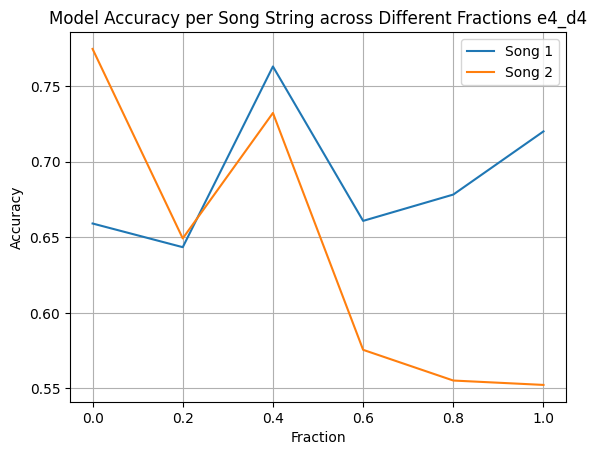

In [46]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e4_d4')
plt.legend()
plt.grid(True)
plt.show()


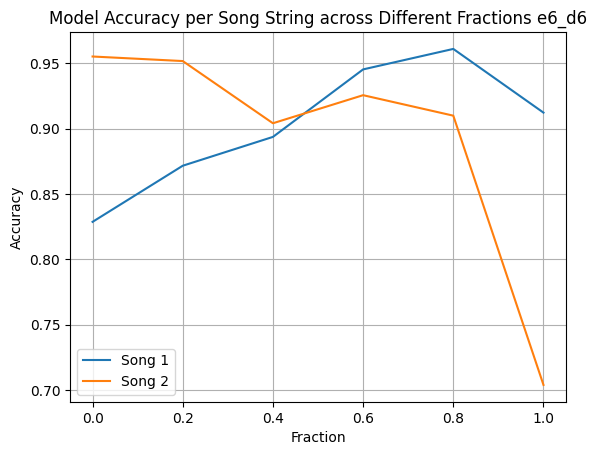

In [43]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e6_d6')
plt.legend()
plt.grid(True)
plt.show()


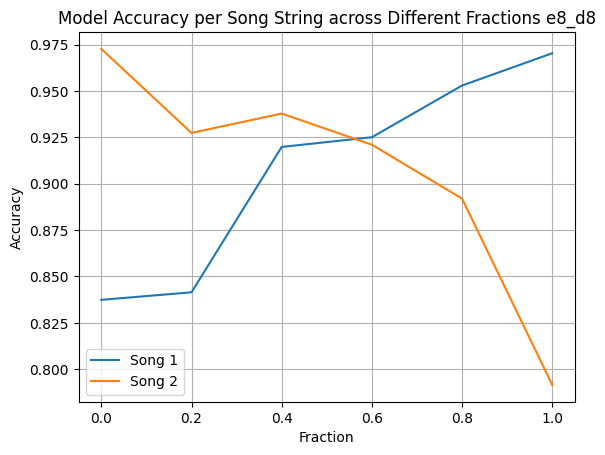

In [40]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e8_d8')
plt.legend()
plt.grid(True)
plt.show()


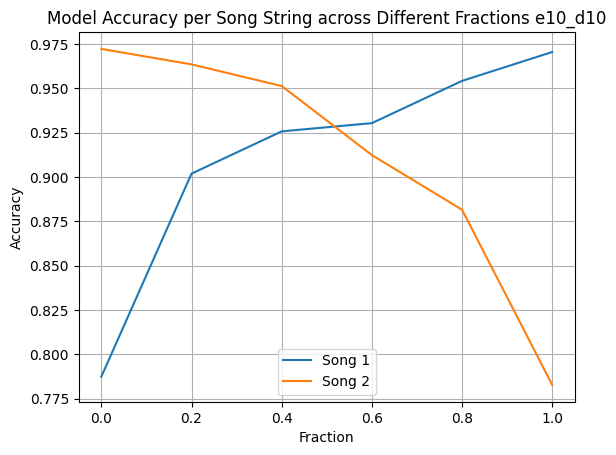

In [37]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e10_d10')
plt.legend()
plt.grid(True)
plt.show()


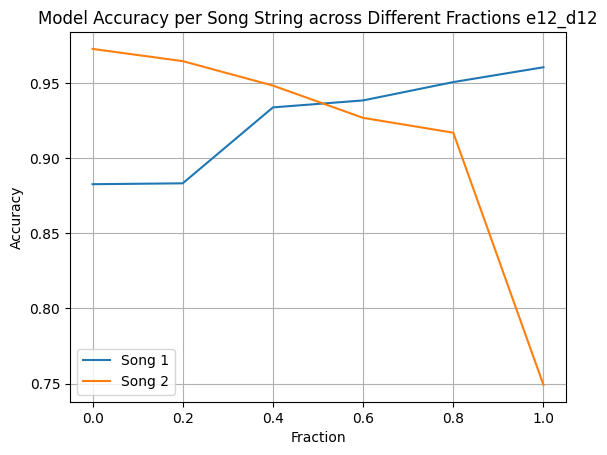

In [34]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e12_d12')
plt.legend()
plt.grid(True)
plt.show()


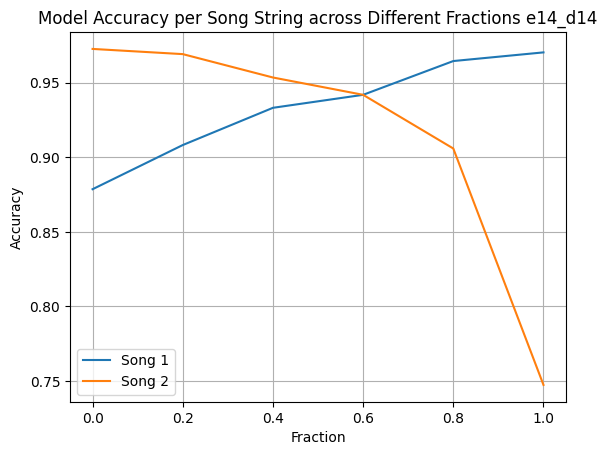

In [31]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e14_d14')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
def test_focused(model, source, target, focus_indices):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source_tensor = torch.tensor(source, dtype=torch.long)
    target_tensor = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source_tensor.transpose(0, 1)  # Adjust for the expected input dimensions
        tgt = target_tensor.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        predictions = output.argmax(dim=2)  # Get the most likely token predictions
        
        # Focus only on the indices of the differing notes
        for idx in focus_indices:
            correct += (predictions[idx] == tgt[idx]).sum().item()
            total += tgt[idx].size(0)  # Update total based on focused indices
        
    accuracy = correct / total  # Calculate the focused accuracy
    return accuracy


In [48]:
# Example song strings for simplicity
song1 = "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC"
song2 = "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEABEF"

# Find differing indices (this is a simplified approach for illustration)
focus_indices = [i for i, (c1, c2) in enumerate(zip(song1, song2)) if c1 != c2]


In [49]:
focus_indices

[38, 39, 40, 41]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_18221/2216166357.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_18221/2216166357.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather t

Epoch 1, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 101, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 201, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 301, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 401, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 501, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 601, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 701, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 801, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 901, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1001, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1101, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1201, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1301, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1401, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1501, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1601, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1701, Loss: 0.0000
s

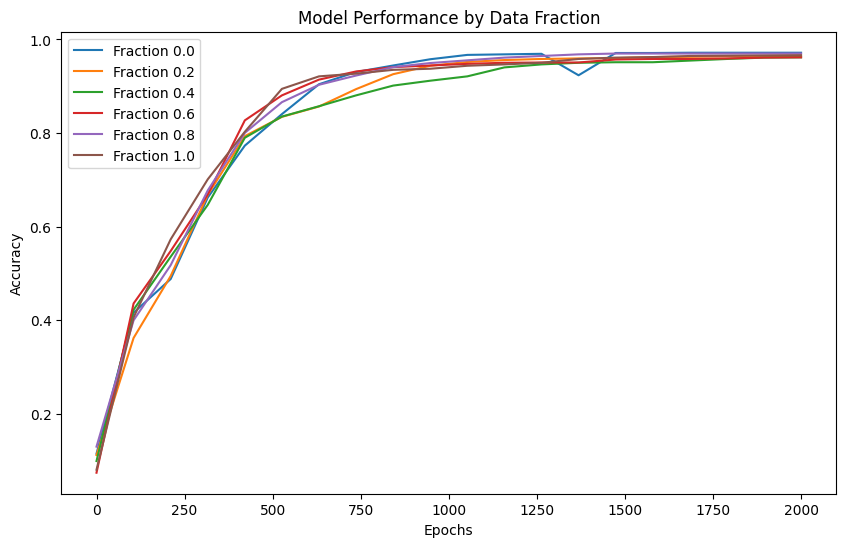

In [50]:
# four notes

# Initialize parameters for the model and environment setup
ntokens = 9  # Size of vocabulary
emsize = 8  # Embedding dimension
nhead = 2  # Number of heads in the nn.MultiheadAttention
d_hid = 8  # Dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # Number of nn.TransformerEncoderLayer
dropout = 0.03  # Dropout probability
learning_rate = 1e-3
num_epochs = 2000
fractions = np.arange(0, 101, 20) / 100
model_dir = "overlap_transformers_four_notes_focused"
os.makedirs(model_dir, exist_ok=True)

source, target = getTrainingData(songStrings, 2)  # Assume this function is properly defined

# Dictionary to store accuracy lists for each fraction
fraction_accuracies = {}

for fraction in fractions:
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

    W = []  # Reset W for each fraction
    model.train()  # Set the model to training mode
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        
        optimizer.zero_grad()  # Clear the gradients
        
        source_tensor = torch.tensor(input_list, dtype=torch.long)
        target_tensor = torch.tensor(output_list, dtype=torch.long)

        src = source_tensor.transpose(0, 1)
        tgt = target_tensor.transpose(0, 1)
        
        output = model(src)
        
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:  # Record accuracy at specified interval
            avg_loss = total_loss / src.size(1)
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            
            acc = test(model, source_tensor, target_tensor)  # Assume this function returns accuracy
            W.append(acc)

    fraction_accuracies[fraction] = W  # Store accuracies for the current fraction

    model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
    torch.save(model.state_dict(), model_save_path)

# Plot all accuracies in the same plot
plt.figure(figsize=(10, 6))
for fraction, accuracies in fraction_accuracies.items():
    epochs = np.linspace(0, num_epochs, len(accuracies))  # Assuming accuracies are recorded evenly throughout training
    plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance by Data Fraction')
plt.legend()
plt.show()


In [53]:
#last four notes
fractions = np.arange(0, 101, 20) / 100

# Define a directory to save/load models
model_dir = "overlap_transformers_four_notes_focused"

# Assuming getTrainingData and split_and_shuffle_data_randomly_based_on_fraction are defined as before

# Load the song strings
songStrings = np.array([
     "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
     "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEABEF"
])

# Initialize the model parameters here (ntokens, emsize, etc.), same as during training
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

accuracies = np.zeros((len(fractions), len(songStrings))) 
 # For storing accuracies of each song at each fraction
for frac_idx, fraction in enumerate(fractions):

    for song_idx, song in enumerate(songStrings):
        
        source, target = getTrainingData(np.array([song]), 1)  # Get data for the current song

        # for frac_idx, fraction in enumerate(fractions):

        model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        model.load_state_dict(torch.load(model_path))
        model.eval()  # Set the model to evaluation mode

        correct = 0
        total = 0

        # input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)
        # source_tensor = torch.tensor(input_list, dtype=torch.long)
        # target_tensor = torch.tensor(output_list, dtype=torch.long)

        source_tensor = torch.tensor(source, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)

        with torch.no_grad():
            
            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            predictions = output.argmax(dim=2)

            for idx in focus_indices:
                correct += (predictions[idx] == tgt[idx]).sum().item()
                total += tgt[idx].size(0)  # Update total based on focused indices

        accuracy = correct / total
        accuracies[frac_idx, song_idx] = accuracy  # Store accuracy for this song at this fraction

# Print or process the accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for song {song_idx}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"Fraction: {fraction}, Accuracy: {accuracies[frac_idx, song_idx]}")


IndexError: index 41 is out of bounds for dimension 0 with size 41

In [55]:

# Define fractions and model directory
fractions = np.arange(0, 101, 20) / 100
model_dir = "overlap_transformers_four_notes_focused"
os.makedirs(model_dir, exist_ok=True)  # Ensure directory exists

# Placeholder song strings
songStrings = np.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEABEF"
])

# Initialize accuracies array to store focused accuracies
accuracies = np.zeros((len(fractions), len(songStrings)))

# Indices of the last four notes
focus_indices = np.array([38, 39, 40, 41])

# Main loop to calculate focused accuracies
for frac_idx, fraction in enumerate(fractions):
    for song_idx, song in enumerate(songStrings):
        source, target = getTrainingData(np.array([song]), 1)
        model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        
        # Load the trained model
        model.load_state_dict(torch.load(model_path))
        model.eval()
        
        source_tensor = torch.tensor(source, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)

        with torch.no_grad():
            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            predictions = output.argmax(dim=2)
            
            # Extract focused sections for predictions and targets
            focused_predictions = predictions[-4:]  # Assuming the last 4 notes are at the end
            focused_targets = tgt[-4:]
            
            # Calculate focused accuracy
            focused_correct = (focused_predictions == focused_targets).sum().item()
            focused_total = focused_targets.numel()
            
            accuracy = focused_correct / focused_total
            accuracies[frac_idx, song_idx] = accuracy

# Print focused accuracies
for song_idx, song in enumerate(songStrings):
    print(f"Focused Accuracies for song {song_idx}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"Fraction: {fraction}, Focused Accuracy: {accuracies[frac_idx, song_idx]:.4f}")

Focused Accuracies for song 0:
Fraction: 0.0, Focused Accuracy: 0.7083
Fraction: 0.2, Focused Accuracy: 0.8452
Fraction: 0.4, Focused Accuracy: 0.9286
Fraction: 0.6, Focused Accuracy: 0.9524
Fraction: 0.8, Focused Accuracy: 0.9940
Fraction: 1.0, Focused Accuracy: 1.0000
Focused Accuracies for song 1:
Fraction: 0.0, Focused Accuracy: 1.0000
Fraction: 0.2, Focused Accuracy: 0.9940
Fraction: 0.4, Focused Accuracy: 0.9821
Fraction: 0.6, Focused Accuracy: 0.8571
Fraction: 0.8, Focused Accuracy: 0.8988
Fraction: 1.0, Focused Accuracy: 0.7143


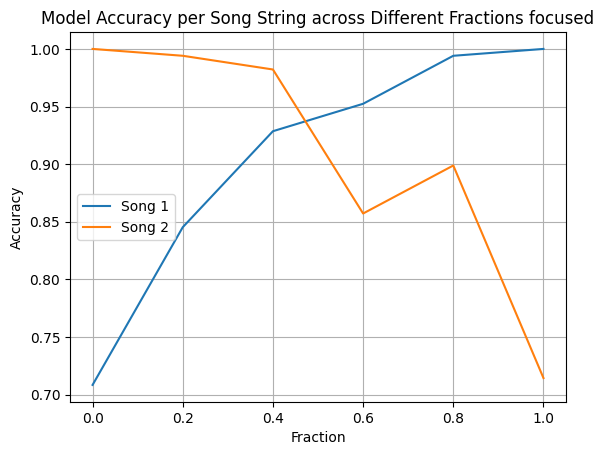

In [56]:

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions focused')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# # Define the fractions
# fractions = np.arange(0, 101, 20) / 100

# # Initialize parameters for the model
# ntokens = 9  # size of vocabulary
# emsize = 6  # embedding dimension
# nhead = 2  # number of heads in the nn.MultiheadAttention
# d_hid = 6  # dimension of the feedforward network model in nn.TransformerEncoder
# nlayers = 2  # number of nn.TransformerEncoderLayer
# dropout = 0.03  # dropout probability
# learning_rate = 1e-3
# num_epochs = 2000

# model_dir = "overlap transformers models up down"
# os.makedirs(model_dir, exist_ok=True)

# source, target = getTrainingData(songStrings, 2)

# for fraction in fractions:

#     model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

#     W=[]
#     model.train()  # Set the model to training mode
#     criterion = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

#     for epoch in range(num_epochs):
#         total_loss = 0
        
#         # Here, we assume batching is handled externally, and source is directly fed into the model
#         optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        
#         source_tensor = torch.tensor(input_list, dtype=torch.long)
#         target_tensor = torch.tensor(output_list, dtype=torch.long)

#         # Adjust for PyTorch expecting (sequence_length, batch_size), so we transpose source and target
#         src = source_tensor.transpose(0, 1)  # Now shape [41, sentences]
#         tgt = target_tensor.transpose(0, 1)  # Now shape [41, sentences]
        
#         output = model(src)  # Forward pass: compute the output of the model
        
#         # Output is [sequence_length, batch_size, ntokens], target is [sequence_length, batch_size]
#         # Flatten output to [sequence_length*batch_size, ntokens] for compatibility with CrossEntropyLoss
#         output_flat = output.view(-1, model.ntokens)
#         tgt_flat = tgt.reshape(-1)
        
#         loss = criterion(output_flat, tgt_flat)  # Compute the loss
#         loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
#         optimizer.step()  # Perform a single optimization step (parameter update)
        
#         total_loss += loss.item()
        
#         avg_loss = total_loss / src.size(1)  # average loss per sentence

#         if epoch % 100 == 0:
#             print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            
#             W.append(test(model,source_tensor,target_tensor))

#             print("acc:",W[-1])
        
#         input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

#     plot(W)

#     model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')

#     torch.save(model.state_dict(), model_save_path)
    
#     print(f"Model saved at {model_save_path}")


# Training for up down Notes

In [6]:
#up down

def getTrainingData(songStrings, nrOfSongs):
    notes = list("ABCDEFGHI")
    chord = [[0], [1], [2], [3], [4], [5], [6], [7],[8]]
    source = []
    target = []
    for s in range(nrOfSongs):
        for i in range(42):
            sentence = []
            answer = []
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return np.array(source), np.array(target)

def split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction):
    total_rows = source.shape[0] // 2
    first_set_rows = int(total_rows * fraction)
    second_set_rows = total_rows - first_set_rows

    first_set_indices = np.random.choice(range(total_rows), first_set_rows, replace=False)
    second_set_indices = np.random.choice(range(total_rows, 2 * total_rows), second_set_rows, replace=False)

    combined_indices = np.concatenate((first_set_indices, second_set_indices))
    np.random.shuffle(combined_indices)

    input_list = source[combined_indices]
    output_list = target[combined_indices]

    return input_list, output_list

# Data generation and preparation
songStrings = np.array([
    "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
    "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED"
])

source_mixed, target_mixed = getTrainingData(songStrings, 2)
fraction = 0.5
input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source_mixed, target_mixed, fraction)

print(input_list.shape, output_list.shape)


(42, 41) (42, 41)


Epoch 1, Loss: 0.0000
sssssssssss torch.Size([41, 42])


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_18221/2216166357.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_18221/2216166357.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Epoch 101, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 201, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 301, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 401, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 501, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 601, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 701, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 801, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 901, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 1, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 101, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 201, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 301, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 401, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 501, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 601, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 701, Loss: 0.0000
sssssssssss torch.Size([41, 42])
Epoch 801, Loss: 0.0000
sssssssss

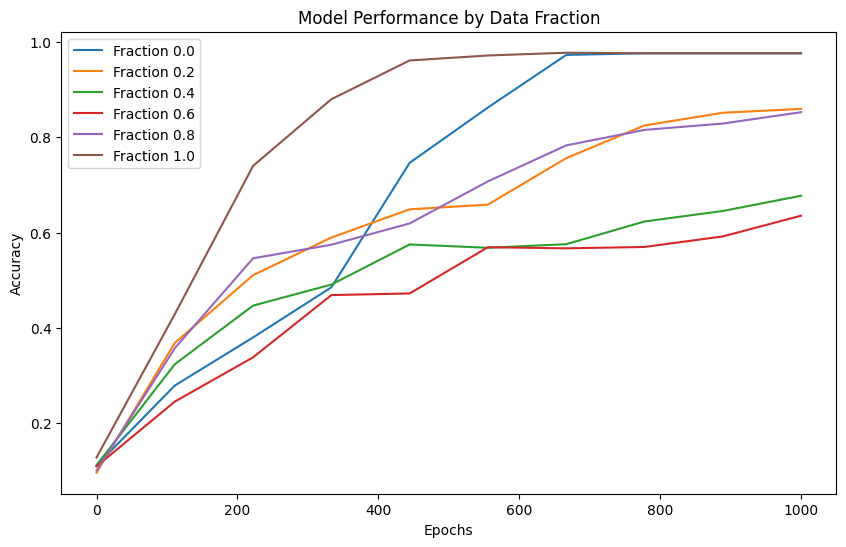

In [25]:
#  up down training

# Initialize parameters for the model and environment setup
ntokens = 9  # Size of vocabulary
emsize = 4  # Embedding dimension
nhead = 2  # Number of heads in the nn.MultiheadAttention
d_hid = 4  # Dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # Number of nn.TransformerEncoderLayer
dropout = 0.03  # Dropout probability
learning_rate = 1e-3
num_epochs = 1000
fractions = np.arange(0, 101, 20) / 100
model_dir = "overlap_transformers_up_down_e4_d4"
os.makedirs(model_dir, exist_ok=True)

source, target = getTrainingData(songStrings, 2)  # Assume this function is properly defined

# Dictionary to store accuracy lists for each fraction
fraction_accuracies = {}

for fraction in fractions:
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

    W = []  # Reset W for each fraction
    model.train()  # Set the model to training mode
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        
        optimizer.zero_grad()  # Clear the gradients
        
        source_tensor = torch.tensor(input_list, dtype=torch.long)
        target_tensor = torch.tensor(output_list, dtype=torch.long)

        src = source_tensor.transpose(0, 1)
        tgt = target_tensor.transpose(0, 1)
        
        output = model(src)
        
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:  # Record accuracy at specified interval
            avg_loss = total_loss / src.size(1)
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            
            acc = test(model, source_tensor, target_tensor)  # Assume this function returns accuracy
            W.append(acc)

    fraction_accuracies[fraction] = W  # Store accuracies for the current fraction

    model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
    torch.save(model.state_dict(), model_save_path)

# Plot all accuracies in the same plot
plt.figure(figsize=(10, 6))
for fraction, accuracies in fraction_accuracies.items():
    epochs = np.linspace(0, num_epochs, len(accuracies))  # Assuming accuracies are recorded evenly throughout training
    plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance by Data Fraction')
plt.legend()
plt.show()


In [26]:
#up down
fractions = np.arange(0, 101, 20) / 100

# Define a directory to save/load models
model_dir = "overlap_transformers_up_down_e4_d4"

# Assuming getTrainingData and split_and_shuffle_data_randomly_based_on_fraction are defined as before

# Load the song strings
songStrings = np.array([
     "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF",
     "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED"
])

# Initialize the model parameters here (ntokens, emsize, etc.), same as during training
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

accuracies = np.zeros((len(fractions), len(songStrings))) 
 # For storing accuracies of each song at each fraction
for frac_idx, fraction in enumerate(fractions):

    for song_idx, song in enumerate(songStrings):
        
        source, target = getTrainingData(np.array([song]), 1)  # Get data for the current song

        # for frac_idx, fraction in enumerate(fractions):

        model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        model.load_state_dict(torch.load(model_path))
        model.eval()  # Set the model to evaluation mode

        correct = 0
        total = 0

        # input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)
        # source_tensor = torch.tensor(input_list, dtype=torch.long)
        # target_tensor = torch.tensor(output_list, dtype=torch.long)

        source_tensor = torch.tensor(source, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)

        with torch.no_grad():
            
            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            predictions = output.argmax(dim=2)

            correct += (predictions == tgt).sum().item()
            total += tgt.numel()

        accuracy = correct / total
        accuracies[frac_idx, song_idx] = accuracy  # Store accuracy for this song at this fraction

# Print or process the accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for song {song_idx}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"Fraction: {fraction}, Accuracy: {accuracies[frac_idx, song_idx]}")


Accuracies for song 0:
Fraction: 0.0, Accuracy: 0.09523809523809523
Fraction: 0.2, Accuracy: 0.3948896631823461
Fraction: 0.4, Accuracy: 0.6027874564459931
Fraction: 0.6, Accuracy: 0.6986062717770035
Fraction: 0.8, Accuracy: 0.9576074332171893
Fraction: 1.0, Accuracy: 0.9761904761904762
Accuracies for song 1:
Fraction: 0.0, Accuracy: 0.9761904761904762
Fraction: 0.2, Accuracy: 0.9634146341463414
Fraction: 0.4, Accuracy: 0.7340301974448316
Fraction: 0.6, Accuracy: 0.5975609756097561
Fraction: 0.8, Accuracy: 0.5696864111498258
Fraction: 1.0, Accuracy: 0.10511033681765389


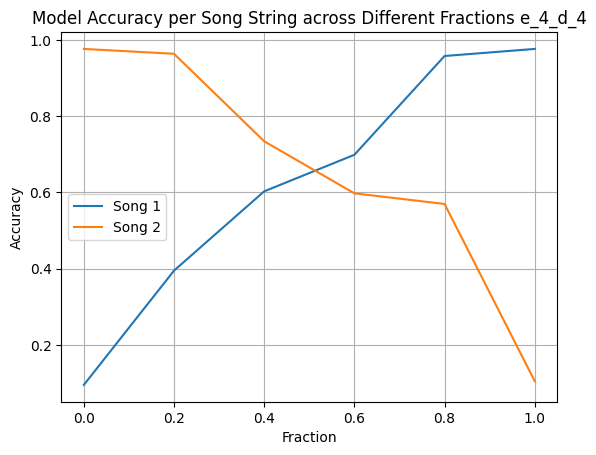

In [27]:
#up down
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e_4_d_4')
plt.legend()
plt.grid(True)
plt.show()


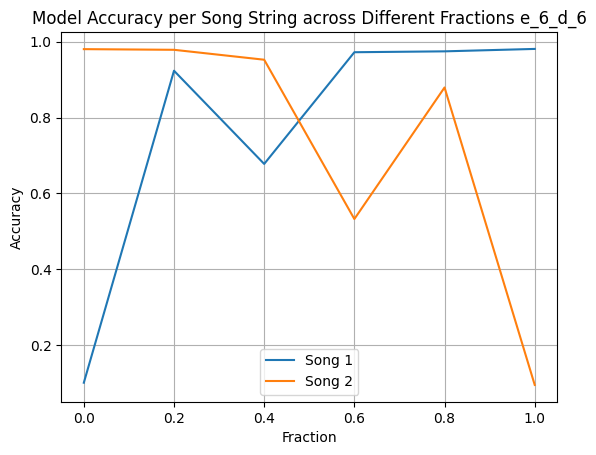

In [24]:
#up down
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e_6_d_6')
plt.legend()
plt.grid(True)
plt.show()


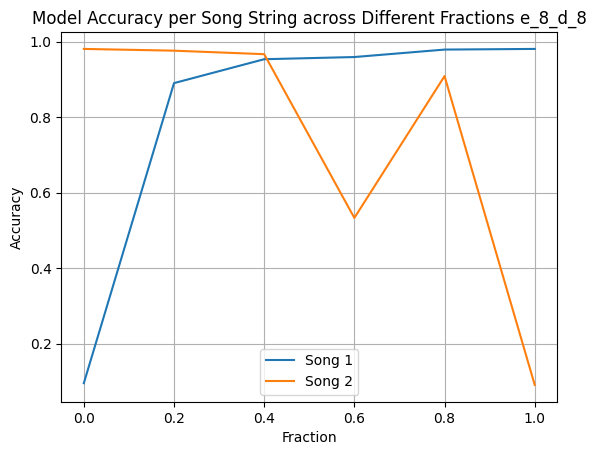

In [21]:
#up down
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e_8_d_8')
plt.legend()
plt.grid(True)
plt.show()


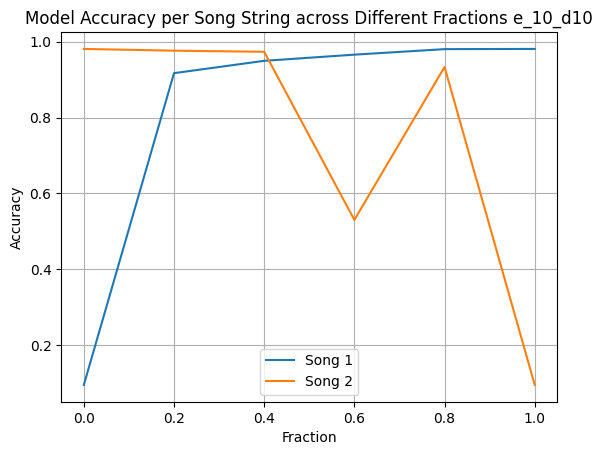

In [12]:
#up down
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e_10_d10')
plt.legend()
plt.grid(True)
plt.show()


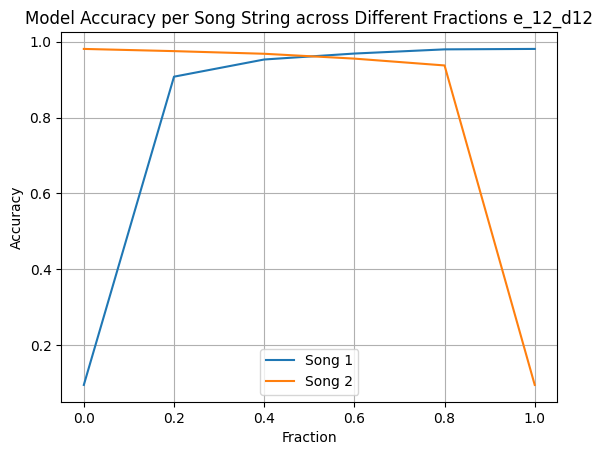

In [15]:
#up down
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e_12_d12')
plt.legend()
plt.grid(True)
plt.show()


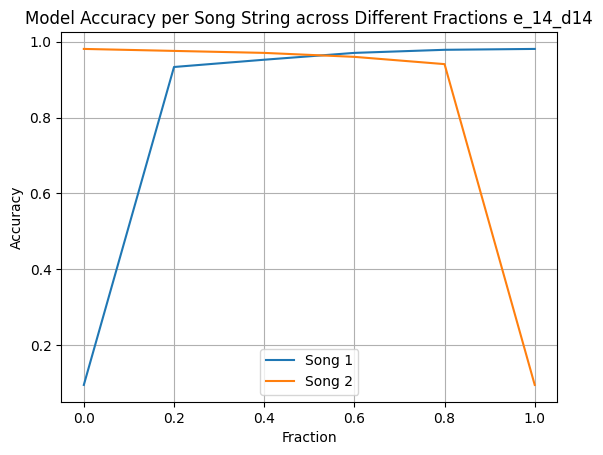

In [18]:
#up down
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions e_14_d14')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# #last four notes reduced parameter

# # Initialize parameters for the model and environment setup
# ntokens = 9  # Size of vocabulary
# emsize = 8  # Embedding dimension
# nhead = 2  # Number of heads in the nn.MultiheadAttention
# d_hid = 8  # Dimension of the feedforward network model in nn.TransformerEncoder
# nlayers = 2  # Number of nn.TransformerEncoderLayer
# dropout = 0.03  # Dropout probability
# learning_rate = 1e-3
# num_epochs = 2000
# fractions = np.arange(0, 101, 20) / 100
# model_dir = "overlap transformers models up down"
# os.makedirs(model_dir, exist_ok=True)

# source, target = getTrainingData(songStrings, 2)  # Assume this function is properly defined

# # Dictionary to store accuracy lists for each fraction
# fraction_accuracies = {}

# for fraction in fractions:
#     model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

#     W = []  # Reset W for each fraction
#     model.train()  # Set the model to training mode
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
#     input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

#     # Training loop
#     for epoch in range(num_epochs):
#         total_loss = 0
        
#         optimizer.zero_grad()  # Clear the gradients
        
#         source_tensor = torch.tensor(input_list, dtype=torch.long)
#         target_tensor = torch.tensor(output_list, dtype=torch.long)

#         src = source_tensor.transpose(0, 1)
#         tgt = target_tensor.transpose(0, 1)
        
#         output = model(src)
        
#         output_flat = output.view(-1, model.ntokens)
#         tgt_flat = tgt.reshape(-1)
        
#         loss = criterion(output_flat, tgt_flat)
#         loss.backward()
#         optimizer.step()
        
#         if epoch % 100 == 0:  # Record accuracy at specified interval
#             avg_loss = total_loss / src.size(1)
#             print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            
#             acc = test(model, source_tensor, target_tensor)  # Assume this function returns accuracy
#             W.append(acc)

#     fraction_accuracies[fraction] = W  # Store accuracies for the current fraction

#     model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
#     torch.save(model.state_dict(), model_save_path)

# # Plot all accuracies in the same plot
# plt.figure(figsize=(10, 6))
# for fraction, accuracies in fraction_accuracies.items():
#     epochs = np.linspace(0, num_epochs, len(accuracies))  # Assuming accuracies are recorded evenly throughout training
#     plt.plot(epochs, accuracies, label=f'Fraction {fraction}')

# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Model Performance by Data Fraction')
# plt.legend()
# plt.show()


In [ ]:
# import numpy as np

# def getTrainingData(songStrings, nrOfSongs):
#     notes = list("ABCDEFGH")
#     chord = [[0], [1], [2], [3], [4], [5], [6], [7]]
#     source = []
#     target = []
#     for s in range(nrOfSongs):
#         for i in range(42):
#             sentence = []
#             answer = []
#             for j in range(41):
#                 sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
#                 answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
#             source.append(sentence)
#             target.append(answer)
#     return np.array(source), np.array(target)

# def split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction):
#     total_rows = source.shape[0] // 2
#     first_set_rows = int(total_rows * fraction)
#     second_set_rows = total_rows - first_set_rows

#     first_set_indices = np.random.choice(range(total_rows), first_set_rows, replace=False)
#     second_set_indices = np.random.choice(range(total_rows, 2 * total_rows), second_set_rows, replace=False)

#     combined_indices = np.concatenate((first_set_indices, second_set_indices))
#     np.random.shuffle(combined_indices)

#     input_list = source[combined_indices]
#     output_list = target[combined_indices]

#     return input_list, output_list

# # Data generation and preparation
# songStrings = np.array([
#     "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
#     "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEABEF"
# ])

# source_mixed, target_mixed = getTrainingData(songStrings, 2)
# fraction = 0.5
# input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source_mixed, target_mixed, fraction)

# print(input_list.shape, output_list.shape)
